In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

random.seed(1220)

This script will generate example decision-making data on a very simple college admissions process, consisting of three groups with equivalent distributions in innate TestingAbility to graduate college. However, some groups have a higher likelihood of receiving application assistance in the form of test prep. Each applicant gets an entrance test score, which we assume to be a function of their individual graduation likelihood plus some constant boost if they've recieved test prep. Thus, admissions teams using test scores to predict a student's likelihood of graduation are somewhat misled by this test prep effect.

In [2]:
sim_params =  {
    'POP_SIZE' : 50000,
    'POP_RATIO' : [1/5, 1/5],
    'GROUPS' : ['A', 'B'],
    'HSI_VALUE_ADDED_MEAN' : {1 : 17, 
                            0 : 0},
    'HSI_VALUE_ADDED_SD' : {1 : 5, 
                            0 : 5},                        
    'GROUP_HSI' : {'A': .8, 
                'B': .2},
    'GROUP_COLLEGE_FUND_ALPHA': {'A' : 4,
                                'B' : 2},   
    'GROUP_COLLEGE_FUND_BETA': {'A' : 1,
                                'B' : .8},                 
    'TRUE_RATING_MEAN' : 100,
    'TRUE_RATING_SD' : 10,
    'TESTING_ABILITY_SD' : 10,
}

# MODEL_PREDICTORS =  ['TestScore', 'HighSchool_Indigo', 'CollegeFund']

MODEL_PREDICTORS =  ['TestScore', 'HighSchool_Indigo']

def sim_graduation(admissions_data):
    admissions_data.loc[:,'Actual_Graduation'] = \
        admissions_data.loc[:,'p_Graduation'].apply(
            lambda x: random.choices([1,0], cum_weights=[x, 1])[0])
    return admissions_data

# Modify ACTUAL predictors in this function - this determines what actually predicts graduation
def calc_grad_prob(sim_admission, noise = 3, offset = 108):
    import math
    sim_admission.loc[:,'p_Graduation'] = sim_admission.apply(
        lambda row: 1/(1+ math.e**(-.2*(
            (row['BaseAbility'] + row['HSValueAdded']) - offset + \
            # (row['BaseAbility'] + row['HSValueAdded'] + row['CollegeFund']) - offset + \
            # (row['BaseAbility'] + row['HSValueAdded'] + math.log1p(row['CollegeFund'])) - offset + \
            int(random.gauss(0, noise))))), axis=1)
    return sim_admission

def sim_admissions_data(POP_SIZE, POP_RATIO, GROUPS, HSI_VALUE_ADDED_MEAN, HSI_VALUE_ADDED_SD,
                        GROUP_HSI, GROUP_COLLEGE_FUND_ALPHA, GROUP_COLLEGE_FUND_BETA, 
                        TRUE_RATING_MEAN, TRUE_RATING_SD, TESTING_ABILITY_SD):
# simulate population consisting of given size and distribution, with a 'true' rating for each student,
# as well as factors that correlate strongly with their true rating
    sim_admission = pd.DataFrame(
        {'Group' : random.choices(GROUPS, weights=POP_RATIO, k = POP_SIZE),
        'BaseAbility': [int(random.gauss(
            TRUE_RATING_MEAN, TRUE_RATING_SD)) for _ in range(POP_SIZE)]})

    ##NOTE this would be more realistic if we call HSValueAdded something harder to observe that 
    ##is disproportionate across groups

    # assign each individual to a high school depending on their likelihood of going to High School Indigo
    sim_admission.loc[:, 'HighSchool_Indigo'] = sim_admission.loc[:, 'Group']\
        .apply(lambda grp: random.choices([1,0], cum_weights=[GROUP_HSI[grp], 1])[0])
    
    # assign a college fund according to the beta distribution
    sim_admission.loc[:, 'CollegeFund'] = sim_admission.loc[:, 'Group']\
        .apply(lambda grp: float(max(random.gammavariate(alpha= GROUP_COLLEGE_FUND_ALPHA[grp],
                                                       beta = GROUP_COLLEGE_FUND_BETA[grp]), 0)))

    # assign each individual a 'value added' from their school's quality
    # (this is assumed to be normally distributed as per fixed effects modelling value added literature)
    sim_admission.loc[:, 'HSValueAdded'] = sim_admission.loc[:, 'HighSchool_Indigo']\
        .apply(lambda hsi: int(random.gauss(HSI_VALUE_ADDED_MEAN[hsi], HSI_VALUE_ADDED_SD[hsi])))

    # assign each individual a 'test ability' (this will encompass the error term in
    # our later regression and is unobserved)
    sim_admission.loc[:, 'TestingAbility'] = [int(random.gauss(0, TESTING_ABILITY_SD)) for _ in range(POP_SIZE)]

    # assign a test score as a function of their actual grad chance, any test prep, and some noise
    sim_admission.loc[:, 'TestScore'] = \
        (sim_admission.loc[:, 'BaseAbility'] + 
        sim_admission.loc[:, 'HSValueAdded'] / 2 +
        sim_admission.loc[:, 'TestingAbility'])
    
    return sim_admission

In [3]:
sim_admission = sim_admissions_data(**sim_params)
sim_admission.head(15)

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore
0,A,104,1,4.049274,23,-13,102.5
1,B,92,0,2.538603,-5,-6,83.5
2,A,92,1,3.287709,18,4,105.0
3,A,81,1,3.360536,15,1,89.5
4,B,97,0,2.046376,7,-11,89.5
5,B,107,1,1.902219,20,-10,107.0
6,A,114,1,6.656852,15,4,125.5
7,B,107,0,3.239730,-12,-11,90.0
8,B,92,0,3.132124,-3,0,90.5
9,B,80,1,2.159165,11,-6,79.5


In [4]:
# sns.pairplot(sim_admission, hue = 'Group', corner = True)


Now, we need to simulate which students succeed in graduating. To do so, I will map ratings to a logistic function: $$ \frac{1}{1+e^{\frac{x}{10} - 11}} $$ where x is the `BaseAbility` for a student.

In [5]:
sim_admission

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore
0,A,104,1,4.049274,23,-13,102.5
1,B,92,0,2.538603,-5,-6,83.5
2,A,92,1,3.287709,18,4,105.0
3,A,81,1,3.360536,15,1,89.5
4,B,97,0,2.046376,7,-11,89.5
...,...,...,...,...,...,...,...
49995,A,85,1,1.770853,16,-2,91.0
49996,A,108,1,5.513194,20,-12,106.0
49997,B,99,0,1.280328,-3,2,99.5
49998,A,105,1,3.625691,18,-2,112.0


<AxesSubplot:xlabel='CollegeFund', ylabel='Count'>

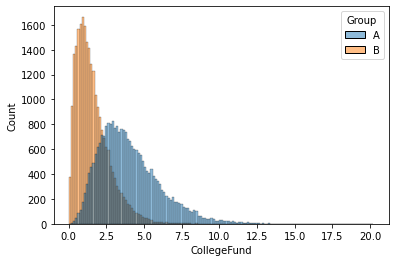

In [6]:
import math
# sns.histplot(x = sim_admission['CollegeFund'].apply(math.log1p), hue = sim_admission['Group'])
sns.histplot(x = sim_admission['CollegeFund'], hue = sim_admission['Group'])

In [7]:
sim_admission = calc_grad_prob(sim_admission)

<AxesSubplot:xlabel='BaseAbility', ylabel='p_Graduation'>

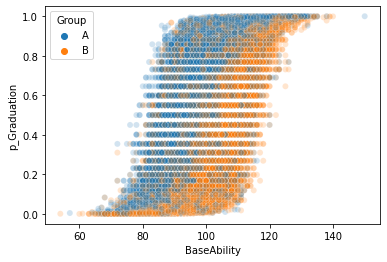

In [8]:
sns.scatterplot(data = sim_admission, x = 'BaseAbility', y = 'p_Graduation', hue= 'Group', alpha = .2)

And now, flip the (weighted) coin for each student according to their probTestingAbility of graduating to get their actual graduation outcome.

In [9]:
sim_admission = sim_graduation(sim_admission)

In [10]:
sim_admission.head()

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore,p_Graduation,Actual_Graduation
0,A,104,1,4.049274,23,-13,102.5,0.952574,1
1,B,92,0,2.538603,-5,-6,83.5,0.017986,0
2,A,92,1,3.287709,18,4,105.0,0.450166,1
3,A,81,1,3.360536,15,1,89.5,0.069138,0
4,B,97,0,2.046376,7,-11,89.5,0.310026,0


In [11]:
#NOTE group only kept in here for the purpose of stratified k-fold - it will not be used as a predictor
X = sim_admission.loc[:,set(MODEL_PREDICTORS + ['Group'])]
Y = sim_admission.loc[:,'Actual_Graduation']

In [12]:
from sklearn import linear_model
from sklearn import model_selection

best_acc = 0
skf = model_selection.StratifiedKFold(n_splits = 10)
# stratified k-fold will split to ensure balance on categorical groups - in our case,
# the group variable. 

if 'Group' in MODEL_PREDICTORS:
    X.loc[:,'Group'] = (X.loc[:,'Group'] == 'A').apply(int)

for idx, (train_index, test_index) in enumerate(skf.split(X, Y)):
    #split into train and test, drop group as a variable for prediction

    x_train_fold = X.iloc[train_index,:].loc[:,MODEL_PREDICTORS]
    y_train_fold = Y.iloc[train_index]
    x_test_fold = X.iloc[test_index,:].loc[:,MODEL_PREDICTORS]
    y_test_fold = Y.iloc[test_index]

    RatingPrediction = linear_model.LogisticRegression()

    #get data 
    RatingPrediction.fit(x_train_fold, y_train_fold)
    predicted_graduation = RatingPrediction.predict(x_test_fold)
    acc = np.mean(predicted_graduation == y_test_fold) # average number of correct predictions
    if acc > best_acc:
        best_acc = acc
        best_model = RatingPrediction

Now, using our best model from the stratified cross-validation, we have a model that predicts graduation correctly most of the time.

In [13]:
best_acc

0.7648

In [14]:
sim_admission_pred = sim_admission.copy(deep = True)
if 'Group' in MODEL_PREDICTORS:
    sim_admission_pred.loc[:,'Group'] = (sim_admission_pred.loc[:,'Group'] == 'A').apply(int)

sim_admission.loc[:,'Predicted_p_Graduation'] = best_model.predict_proba(sim_admission_pred.loc[:,MODEL_PREDICTORS])[:,1]

In [15]:
sim_admission.head()

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore,p_Graduation,Actual_Graduation,Predicted_p_Graduation
0,A,104,1,4.049274,23,-13,102.5,0.952574,1,0.673412
1,B,92,0,2.538603,-5,-6,83.5,0.017986,0,0.077654
2,A,92,1,3.287709,18,4,105.0,0.450166,1,0.715267
3,A,81,1,3.360536,15,1,89.5,0.069138,0,0.424809
4,B,97,0,2.046376,7,-11,89.5,0.310026,0,0.119120


Mean predicted graduation rates are equivalent between groups and unbiased (though only moderate in precision, leading to an overall 75% accuracy seen above)

<ipython-input-16-d04bfadd324e>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','0-10%', '20-30%', '40-50%', '60-70%', '80-90%'])


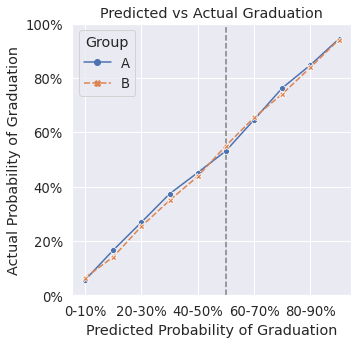

In [16]:
from matplotlib import ticker
bins, labels = pd.cut((sim_admission.loc[:,'Predicted_p_Graduation']*100).apply(int), bins = np.arange(-10,110,10), right = False).factorize(sort = True)

sim_admission.loc[:,'Predicted_p_Graduation_bin'] = bins
lineplot_admin = sim_admission.groupby(['Predicted_p_Graduation_bin', 'Group'])['Actual_Graduation'].apply(lambda x: np.mean(x) * 100).reset_index()

sns.set(rc={"figure.figsize":(5, 5)}) 
sns.set(font_scale=1.2)

ax = sns.lineplot(data = lineplot_admin,
            x = 'Predicted_p_Graduation_bin',
            y = 'Actual_Graduation',
            hue = 'Group',
            style= 'Group',
            markers = True)
plt.xlabel('Predicted Probability of Graduation')
plt.ylabel('Actual Probability of Graduation')
plt.title('Predicted vs Actual Graduation')
ax.vlines(x = 5, ymin = 0, ymax = 100, linestyle = 'dashed', color = 'grey')
ax.set(ylim = (0,100))
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xticklabels(['','0-10%', '20-30%', '40-50%', '60-70%', '80-90%'])

plt.savefig('Predicted_vs_Actual.png', bbox_inches="tight")

As we see below - no significant bias in the difference between predicted and actual graduation rates between groups. 

(-0.05, 0.05)

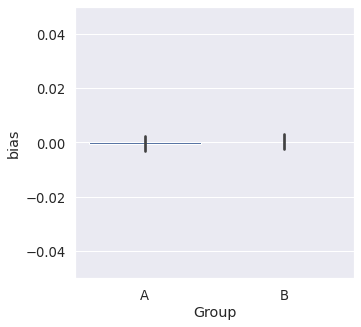

In [17]:
sim_admission.loc[:,'bias'] = sim_admission['p_Graduation'] - sim_admission['Predicted_p_Graduation']
sns.barplot(data = sim_admission, x = 'Group', y = 'bias')

plt.ylim((-.05,.05))

In [18]:
np.arange(0,1.1,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(sim_admission.loc[:,'Actual_Graduation'], sim_admission.loc[:,'Predicted_p_Graduation'])
precision_recall = pd.DataFrame({'precision' : precision[1:],
                                            'recall'  : recall[1:],
                                            'threshold' : thresholds,
                                            'group' : 'A'})

precision_recall.loc[:, 'precision_round'] = precision_recall['precision'].apply(lambda x: round(x, ndigits = 3)*100)
precision_recall.loc[:, 'recall_round'] = precision_recall['recall'].apply(lambda x: round(x, ndigits = 3)*100)

thresh_points = pd.DataFrame()
for thresh in np.arange(0,1.1,.1):
    precision_recall['decision_dist'] = abs(precision_recall['threshold']-thresh)
    decision_bound = precision_recall['decision_dist'].min()
    opt_mask = precision_recall['decision_dist'] == decision_bound
    opt = precision_recall[opt_mask]
    opt = opt.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
    opt.loc[:,'thresh_lab'] = thresh
    thresh_points = pd.concat([thresh_points, opt], axis = 0)
thresh_points



,precision,recall,threshold,precision_round,recall_round,decision_dist,thresh_lab
group,,,,,,,
A,0.494812,0.999959,0.018429,49.5,100.0,0.018429,0.0
A,0.538081,0.987995,0.099909,53.8,98.8,0.000091,0.1
A,0.603252,0.949384,0.202738,60.3,94.9,0.002738,0.2
A,0.662451,0.890128,0.298259,66.2,89.0,0.001741,0.3
A,0.709999,0.825357,0.396225,71.0,82.5,0.003775,0.4
A,0.755748,0.747932,0.503213,75.6,74.8,0.003213,0.5
A,0.799506,0.655986,0.600547,80.0,65.6,0.000547,0.6
A,0.842331,0.534758,0.698977,84.2,53.5,0.001023,0.7
A,0.886442,0.367253,0.801385,88.6,36.7,0.001385,0.8


<ipython-input-20-fb3a9d3fc287>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0%','20%', '40%', '60%', '80%', '100%'])


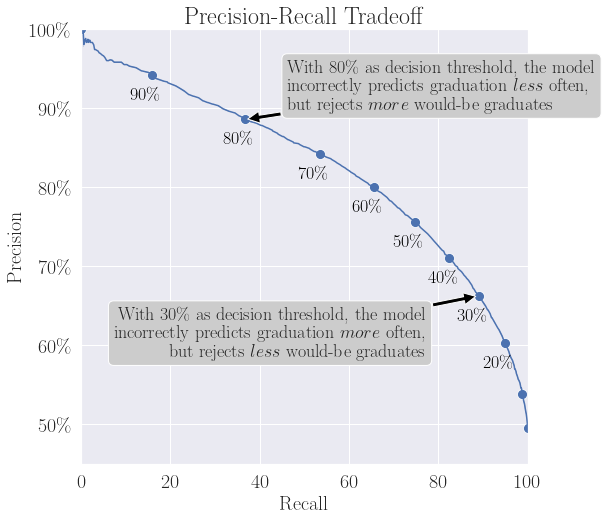

In [20]:
sns.set(rc={"figure.figsize":(8, 8)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig, ax = plt.subplots()
ax = sns.lineplot(data = precision_recall, x = 'recall_round', y = 'precision_round')
sns.scatterplot(data = thresh_points, x = 'recall_round', y = 'precision_round', s=100)

#add axis labels to plot
ax.set_title('Precision-Recall Tradeoff', fontsize = 24)
ax.set_ylabel('Precision', fontsize = 20)
ax.set_xlabel('Recall', fontsize = 20)

ax.yaxis.set_major_formatter(ticker.PercentFormatter())
# ax.set_xticklabels(['','0%','20%', '40%', '60%', '80%', '100%'])
ax.set_xticklabels(['0%','20%', '40%', '60%', '80%', '100%'])

plt.xlim((0,100))
plt.ylim((45,100))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

thresh_labs = (thresh_points['thresh_lab'] * 100).apply(lambda x: str(int(x)) + '\\%')
for score_idx, xy in enumerate(zip(thresh_points['recall_round']-1.5,thresh_points['precision_round']-1.5)):
    if score_idx in np.arange(2,10):
        col = 'black'
        ax.annotate(thresh_labs[score_idx], xy=xy, textcoords='data', ha ='center', va = 'top', color = col)

ax.annotate(
'''With $\t{80\%}$ as decision threshold, the model
incorrectly predicts graduation $\t{less}$ often,
but rejects $\t{more}$ would-be graduates''',
            xy=(thresh_points['recall_round'][8] + .5, 
                thresh_points['precision_round'][8]), xycoords='data',
            xytext=(40,60), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='left', verticalalignment='top')

ax.annotate(
'''With $\t{30\%}$ as decision threshold, the model
incorrectly predicts graduation $\t{more}$ often,
but rejects $\t{less}$ would-be graduates''',
            xy=(thresh_points['recall_round'][3] - .5, 
                thresh_points['precision_round'][3]), xycoords='data',
            xytext=(-50,-10), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='top')

plt.savefig('Precision_Recall_combined.png', bbox_inches="tight")

In [21]:
# plt.rc('text',usetex=False)

precision_recall = pd.DataFrame()

simA = sim_admission[sim_admission['Group'] == 'A']
precision, recall, thresholds = precision_recall_curve(simA.loc[:,'Actual_Graduation'], simA.loc[:,'Predicted_p_Graduation'])
precision_recall = pd.concat([precision_recall, pd.DataFrame({'precision' : precision[1:],
                                            'recall'  : recall[1:],
                                            'threshold' : thresholds,
                                            'group' : 'A'})], axis = 0)

simB = sim_admission[sim_admission['Group'] == 'B']
precision, recall, thresholds = precision_recall_curve(simB.loc[:,'Actual_Graduation'], simB.loc[:,'Predicted_p_Graduation'])
precision_recall = pd.concat([precision_recall, pd.DataFrame({'precision' : precision[1:],
                                            'recall'  : recall[1:],
                                            'threshold' : thresholds,
                                            'group' : 'B'})], axis = 0)

precision_recall.loc[:, 'precision_round'] = precision_recall['precision'].apply(lambda x: round(x, ndigits = 3)*100)
precision_recall.loc[:, 'recall_round'] = precision_recall['recall'].apply(lambda x: round(x, ndigits = 3)*100)


In [22]:
precision_recall['decision_dist'] = abs(precision_recall['precision']-.8)
decision_bound = precision_recall.groupby('group')['decision_dist'].min('decision_dist')
opt_mask = (precision_recall['group'] == 'A') & (precision_recall['decision_dist'] == decision_bound['A']) |\
           (precision_recall['group'] == 'B') & (precision_recall['decision_dist'] == decision_bound['B'])
opt_p = precision_recall[opt_mask]
opt_p = opt_p.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
opt_p

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.800834,0.797762,0.581459,80.1,79.8,0.000834
B,0.801771,0.391637,0.646842,80.2,39.2,0.001771


In [23]:
precision_recall['decision_dist'] = abs(precision_recall['recall']-.8)
decision_bound = precision_recall.groupby('group')['decision_dist'].min('decision_dist')
opt_mask = (precision_recall['group'] == 'A') & (precision_recall['decision_dist'] == decision_bound['A']) |\
           (precision_recall['group'] == 'B') & (precision_recall['decision_dist'] == decision_bound['B'])
opt_r = precision_recall[opt_mask]
opt_r = opt_r.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
opt_r

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.800834,0.797762,0.581459,80.1,79.8,0.002238
B,0.565767,0.799579,0.281997,56.6,80.0,0.000421


In [24]:
precision_recall['decision_dist'] = abs(precision_recall['threshold']-.5)
decision_bound = precision_recall.groupby('group')['decision_dist'].min('decision_dist')
opt_mask = (precision_recall['group'] == 'A') & (precision_recall['decision_dist'] == decision_bound['A']) |\
           (precision_recall['group'] == 'B') & (precision_recall['decision_dist'] == decision_bound['B'])
opt_t = precision_recall[opt_mask]
opt_t = opt_t.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
opt_t

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.771266,0.859143,0.503213,77.1,85.9,0.003213
B,0.717008,0.555013,0.503213,71.7,55.5,0.003213


In [25]:
diffs = opt_t.iloc[1,[0,1]] - opt_t.iloc[0,[0,1]]
m = diffs[0]/diffs[1] 
b = (opt_t.iloc[0,0] - m * opt_t.iloc[0,1])
xs = np.arange(0,1.1,.1)
ys = (m*xs + b)

<ipython-input-26-b6c128eefed5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0\%','20\%', '40\%', '60\%', '80\%', '100\%'])


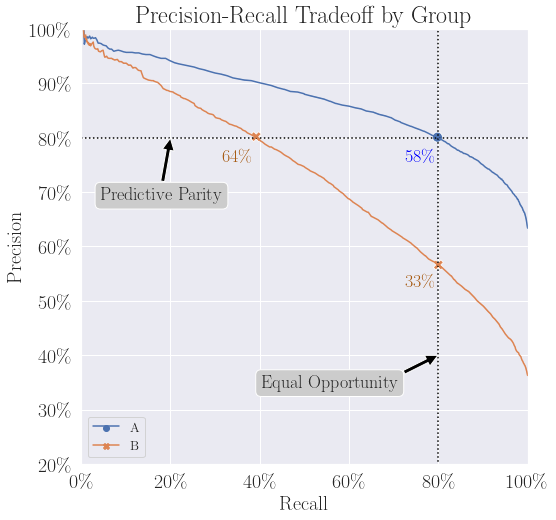

In [26]:
sns.set(rc={"figure.figsize":(8, 8)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)


#create precision recall curve
fig, ax = plt.subplots()
ax = sns.lineplot(data = precision_recall, x = 'recall_round', y = 'precision_round', hue = 'group')


# #add axis labels to plot
ax.set_title('Precision-Recall Tradeoff by Group', fontsize = 24)
ax.set_ylabel('Precision', fontsize = 20)
ax.set_xlabel('Recall', fontsize = 20)

sns.scatterplot(data = opt_p, x = 'recall_round', y = 'precision_round', hue = 'group', style='group', s=100)
sns.scatterplot(data = opt_r, x = 'recall_round', y = 'precision_round', hue = 'group', style='group', s=100)
# sns.scatterplot(data = opt_t, x = 'recall_round', y = 'precision_round', hue = 'group', style='group', s= 100)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[(h1, h2) for h1, h2 in zip(handles[:2], handles[2:])],
           labels=labels[2:],
           loc = 'lower left')

ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xticklabels(['0\%','20\%', '40\%', '60\%', '80\%', '100\%'])
plt.hlines(y = 80, xmin = 0, xmax = 100, linestyles= ':', color = 'black')
plt.vlines(x = 80, ymin = 0, ymax = 100, linestyles= ':', color = 'black')
# plt.plot(xs*100, ys*100, linestyle= ':', color = 'black')

ax.annotate(
'''Predictive Parity''',
            xy=(20,80), xycoords='data',
            xytext=(-70,-50), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='left', verticalalignment='top')

ax.annotate(
'''Equal Opportunity''',
            xy=(80,40), xycoords='data',
            xytext=(-40,-20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('58\%', xy=(76,78), textcoords='data', ha ='center', va = 'top', color = 'blue')
ax.annotate('64\%', xy=(35,78), textcoords='data', ha ='center', va = 'top', color = '#a75b13')
ax.annotate('33\%', xy=(76,55), textcoords='data', ha ='center', va = 'top', color = '#a75b13')

plt.xlim((0,100))
plt.ylim((20,100))

plt.savefig('Precision_Recall_group.png',  bbox_inches="tight")

In [27]:
opt_p

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.800834,0.797762,0.581459,80.1,79.8,0.000834
B,0.801771,0.391637,0.646842,80.2,39.2,0.001771


In [28]:
opt_r

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.800834,0.797762,0.581459,80.1,79.8,0.002238
B,0.565767,0.799579,0.281997,56.6,80.0,0.000421


## "Natural" (50%) cutoff

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


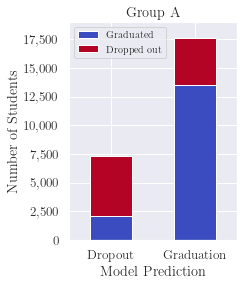

In [29]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})
font = {'family' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('legend', fontsize=10) #fontsize of the legend

hist_datA = sim_admission[(sim_admission['Group'] == 'A')]
hist_datA.loc[:,'predicted_bin'] = pd.cut(hist_datA['Predicted_p_Graduation'], bins = [0,.5,1], right = True)
hist_datA = hist_datA.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()


hist_datB = sim_admission[(sim_admission['Group'] == 'B')]
hist_datB.loc[:,'predicted_bin'] = pd.cut(hist_datB['Predicted_p_Graduation'], bins = [0,.5,1], right = True)
hist_datB = hist_datB.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

max_y = max(max(hist_datA.groupby('predicted_bin')['counts'].sum()),
            max(hist_datB.groupby('predicted_bin')['counts'].sum()))


hst = hist_datA.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
hst = hst.loc[:, ['Graduated','Dropped out']]
ax = hst.plot(kind='bar', stacked = True, colormap = 'coolwarm')
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Graduation'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,max_y + max_y*.05)
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')

plt.savefig('NaturalThresh_A.png', bbox_inches="tight")


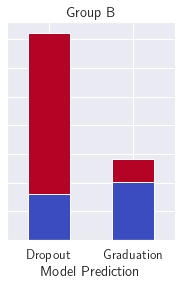

In [30]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})
plt.rc('legend', fontsize=10) #fontsize of the legend

hst = hist_datB.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
hst = hst.loc[:, ['Graduated','Dropped out']]
ax = hst.plot(kind='bar', stacked = True,colormap = 'coolwarm', legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_ylim(0,max_y + max_y*.05)

ax.set_xticklabels(['Dropout', 'Graduation'])
plt.xticks(rotation = 0)

plt.savefig('NaturalThresh_B.png', bbox_inches="tight")


# 'School optimal' cutoff (80% precision)

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


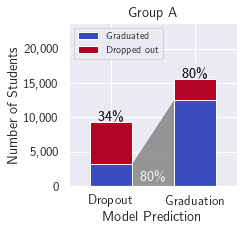

In [31]:
sns.set(rc={"figure.figsize":(3, 3)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})
plt.rc('legend', fontsize=10) #fontsize of the legend

hist_datA = sim_admission[(sim_admission['Group'] == 'A')]
hist_datA.loc[:,'predicted_bin'] = pd.cut(hist_datA['Predicted_p_Graduation'], bins = [0,opt_p['threshold']['A'],1], right = True)
hist_datA = hist_datA.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()


hist_datB = sim_admission[(sim_admission['Group'] == 'B')]
hist_datB.loc[:,'predicted_bin'] = pd.cut(hist_datB['Predicted_p_Graduation'], bins = [0,opt_p['threshold']['B'],1], right = True)
hist_datB = hist_datB.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

max_y = max(max(hist_datA.groupby('predicted_bin')['counts'].sum()),
            max(hist_datB.groupby('predicted_bin')['counts'].sum()))

hst = hist_datA.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
hst = hst.loc[:, ['Graduated','Dropped out']]
ax = hst.plot(kind='bar', stacked = True, colormap = 'coolwarm')
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Graduation'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,max_y + max_y*.15)
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')

annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center')

patches = ax.patches
ax.fill_between([0 + patches[0].get_width()/2,1 - patches[1].get_width()/2], hst['Graduated'],
                alpha = .8,
                color = 'grey')

annot_recall = hst['Graduated'][1] / hst['Graduated'].sum() * 100
ax.annotate('{:.0f}\%'.format(annot_recall), (.5, 750), ha='center', c = 'white')


annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center')

plt.savefig('CountsA_School.png', bbox_inches="tight")



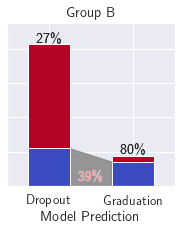

In [32]:
import matplotlib.patheffects as pe

sns.set(rc={"figure.figsize":(3, 3)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})

hst = hist_datB.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
hst = hst.loc[:, ['Graduated','Dropped out']]
ax = hst.plot(kind='bar', stacked = True, legend=None, colormap = 'coolwarm')
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_ylim(0,max_y + max_y*.15)

annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center')

annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center')

patches = ax.patches
ax.fill_between([0 + patches[0].get_width()/2,1 - patches[1].get_width()/2], hst['Graduated'],
                alpha = .8,
                color = 'grey')

annot_recall = hst['Graduated'][1] / hst['Graduated'].sum() * 100
ax.annotate('{:.0f}\%'.format(annot_recall), (.5, 750), ha='center', c = '#f69292',
            path_effects=[pe.withStroke(linewidth=.5, foreground="white")])


ax.set_xticklabels(['Dropout', 'Graduation'])
plt.xticks(rotation = 0)
plt.savefig('CountsB_School.png', bbox_inches="tight")


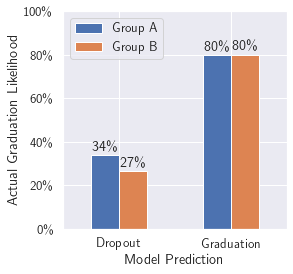

In [33]:
from matplotlib import ticker

sns.set(rc={"figure.figsize":(4, 4)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})

avg_grad_p = sim_admission
avg_grad_p.loc[:,'predicted graduation'] = avg_grad_p.apply(lambda row: int(row['Predicted_p_Graduation'] > opt_p['threshold'][row['Group']]), axis = 1)
avg_grad_p = avg_grad_p.groupby(['Group', 'predicted graduation'])['Actual_Graduation'].mean().apply(lambda x: x*100).reset_index()
avg_grad_p.columns  = ['Group', 'Prediction', 'Graduation Rate']
avg_grad_p = avg_grad_p.set_index('Prediction').pivot(columns='Group')
avg_grad_p.columns = ['Group A', 'Group B']
avg_grad_p.index = 'Dropout', 'Graduation'
ax = avg_grad_p.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+2
   ax.annotate('{:.0f}\%'.format(patches[i].get_height()), (x, y), ha='center')

# ax.annotate(
# '''Equal Opportunity''',
#             xy=(.8,80), xycoords='data',
#             xytext=(-290,-20), textcoords='offset points',
#             arrowprops=dict(facecolor='black', shrink=0.01, alpha = .5),
#             bbox=dict(boxstyle="round", fc="0.8"),
#             horizontalalignment='right', verticalalignment='top')

ax.set_ylim(0,100)
plt.xlabel('Model Prediction')
plt.ylabel('Actual Graduation Likelihood')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.savefig('Predicted_vs_Actual_on_Prediction_School.png', bbox_inches="tight")

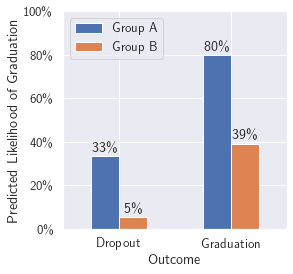

In [34]:
sns.set(rc={"figure.figsize":(4, 4)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})

avg_grad_p = sim_admission
avg_grad_p.loc[:,'predicted_graduation'] = avg_grad_p.apply(lambda row: int(row['Predicted_p_Graduation'] > opt_p['threshold'][row['Group']]), axis = 1)
avg_grad_p = avg_grad_p.groupby(['Group', 'Actual_Graduation'])['predicted_graduation'].mean().apply(lambda x: x*100).reset_index()
avg_grad_p.columns  = ['Group', 'Outcome', 'Graduation Rate']
avg_grad_p = avg_grad_p.set_index('Outcome').pivot(columns='Group')
avg_grad_p.columns = ['Group A', 'Group B']
avg_grad_p.index = 'Dropout', 'Graduation'
ax = avg_grad_p.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+2
   ax.annotate('{:.0f}\%'.format(patches[i].get_height()), (x, y), ha='center')
ax.set_ylim(0,100)
plt.xlabel('Outcome')
plt.ylabel('Predicted Likelihood of Graduation')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.savefig('Predicted_vs_Actual_on_Outcome_School.png', bbox_inches="tight")

# 'Societally Optimal' cutoff (80% Recall)

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


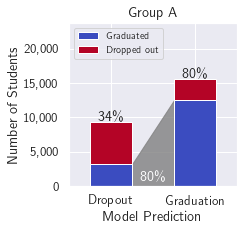

In [35]:
sns.set(rc={"figure.figsize":(3, 3)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})
plt.rc('legend', fontsize=10) #fontsize of the legend

hist_datA = sim_admission[(sim_admission['Group'] == 'A')]
hist_datA.loc[:,'predicted_bin'] = pd.cut(hist_datA['Predicted_p_Graduation'], bins = [0,opt_r['threshold']['A'],1], right = True)
hist_datA = hist_datA.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()


hist_datB = sim_admission[(sim_admission['Group'] == 'B')]
hist_datB.loc[:,'predicted_bin'] = pd.cut(hist_datB['Predicted_p_Graduation'], bins = [0,opt_r['threshold']['B'],1], right = True)
hist_datB = hist_datB.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

# max_y = max(max(hist_datA.groupby('predicted_bin')['counts'].sum()),
#             max(hist_datB.groupby('predicted_bin')['counts'].sum()))


hst = hist_datA.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
hst = hst.loc[:, ['Graduated','Dropped out']]
ax = hst.plot(kind='bar', stacked = True, colormap = 'coolwarm')
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Graduation'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,max_y + max_y*.15)
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')

annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center')

patches = ax.patches
ax.fill_between([0 + patches[0].get_width()/2,1 - patches[1].get_width()/2], hst['Graduated'],
                alpha = .8,
                color = 'grey')

annot_recall = hst['Graduated'][1] / hst['Graduated'].sum() * 100
ax.annotate('{:.0f}\%'.format(annot_recall), (.5, 750), ha='center', c = 'white')

plt.savefig('CountsA_Societal.png', bbox_inches="tight")


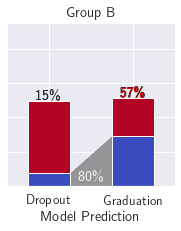

In [36]:
sns.set(rc={"figure.figsize":(3,3)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})

hst = hist_datB.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
hst = hst.loc[:, ['Graduated','Dropped out']]
ax = hst.plot(kind='bar', stacked = True, legend=None, colormap = 'coolwarm')
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_ylim(0,max_y + max_y*.15)

annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center')


annot = hst['Graduated'] / hst.sum(axis = 1) * 100
yloc_annot = hst.sum(axis = 1) + 200
xloc_annot = [0,1]
ax.annotate('{:.0f}\%'.format(annot[0]), (xloc_annot[0], yloc_annot[0]), ha='center')
ax.annotate('{:.0f}\%'.format(annot[1]), (xloc_annot[1], yloc_annot[1]), ha='center', c= 'red',
    path_effects=[pe.withStroke(linewidth=.5, foreground="black")])

patches = ax.patches
ax.fill_between([0 + patches[0].get_width()/2,1 - patches[1].get_width()/2], hst['Graduated'],
                alpha = .8,
                color = 'grey')

annot_recall = hst['Graduated'][1] / hst['Graduated'].sum() * 100
ax.annotate('{:.0f}\%'.format(annot_recall), (.5, 750), ha='center', c = 'white')


ax.set_xticklabels(['Dropout', 'Graduation'])
plt.xticks(rotation = 0)
plt.savefig('CountsB_Societal.png', bbox_inches="tight")


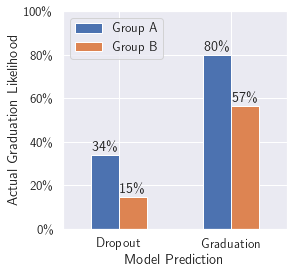

In [37]:
from matplotlib import ticker

sns.set(rc={"figure.figsize":(4, 4)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})

avg_grad_p = sim_admission
avg_grad_p.loc[:,'predicted graduation'] = avg_grad_p.apply(lambda row: int(row['Predicted_p_Graduation'] > opt_r['threshold'][row['Group']]), axis = 1)
avg_grad_p = avg_grad_p.groupby(['Group', 'predicted graduation'])['Actual_Graduation'].mean().apply(lambda x: x*100).reset_index()
avg_grad_p.columns  = ['Group', 'Prediction', 'Graduation Rate']
avg_grad_p = avg_grad_p.set_index('Prediction').pivot(columns='Group')
avg_grad_p.columns = ['Group A', 'Group B']
avg_grad_p.index = 'Dropout', 'Graduation'
ax = avg_grad_p.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+2
   ax.annotate('{:.0f}\%'.format(patches[i].get_height()), (x, y), ha='center')
ax.set_ylim(0,100)
plt.xlabel('Model Prediction')
plt.ylabel('Actual Graduation Likelihood')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.savefig('Predicted_vs_Actual_on_Prediction_Societal.png', bbox_inches="tight")

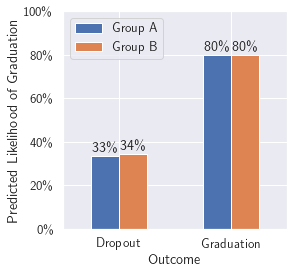

In [38]:
sns.set(rc={"figure.figsize":(4, 4)}) 
sns.set(font_scale=1.2, rc={'text.usetex' : True})

avg_grad_p = sim_admission
avg_grad_p.loc[:,'predicted_graduation'] = avg_grad_p.apply(lambda row: int(row['Predicted_p_Graduation'] > opt_r['threshold'][row['Group']]), axis = 1)
avg_grad_p = avg_grad_p.groupby(['Group', 'Actual_Graduation'])['predicted_graduation'].mean().apply(lambda x: x*100).reset_index()
avg_grad_p.columns  = ['Group', 'Outcome', 'Graduation Rate']
avg_grad_p = avg_grad_p.set_index('Outcome').pivot(columns='Group')
avg_grad_p.columns = ['Group A', 'Group B']
avg_grad_p.index = 'Dropout', 'Graduation'
ax = avg_grad_p.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+2
   ax.annotate('{:.0f}\%'.format(patches[i].get_height()), (x, y), ha='center')
ax.set_ylim(0,100)
plt.xlabel('Outcome')
plt.ylabel('Predicted Likelihood of Graduation')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.savefig('Predicted_vs_Actual_on_Outcome_Societal.png', bbox_inches="tight")